# Data Preperation

***This notebook finds the duplicate images in the dataset.
it create the output file with name: s2_duplicate_list.csv***

file contains following attribute to tag the duplicate images:
1. duplicate: 1 => duplicate, 0 => unique. It is set to 1 only when image is found to be duplicate image within the class 
2. parent_img: contain the reference of its duplicate image


In [1]:
# mount gdrive
mount_drive = True
if mount_drive:
    from google.colab import drive
    drive.mount('/content/gdrive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import os
os.chdir('/content/gdrive/My Drive/TSAI/EVA4_Phase2/session2/')
print(os.getcwd())

/content/gdrive/My Drive/TSAI/EVA4_Phase2/session2


In [3]:
# import all necessary packages
import warnings 
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns

import time
import os
from tqdm import tqdm # for progress indication

**Read the images and generate the train and test dataset**

In [4]:
class_list = ['Flying Birds', 'Large QuadCopters', 'Small QuadCopters', 'Winged Drones']
class_list_shortname = ['FB', 'LQC', 'SQC', 'WD']
pd.DataFrame({'class': class_list, 'shortname': class_list_shortname})

,class,shortname
0,Flying Birds,FB
1,Large QuadCopters,LQC
2,Small QuadCopters,SQC
3,Winged Drones,WD


In [5]:
from pathlib import Path

# dataset path where zip files are placed
src_dataset_dir = '/content/gdrive/My Drive/TSAI/EVA4_Phase2/datasets/s2_dataset/'

#unzip locations: note path shall be colab internal memory location not on mounted drive.
root_dataset = '/content/eva4p2_s2_dataset2'

In [6]:
# Extracting zipped dataset into colab internal memory
%%time

import zipfile
def extract_dataset(fn, dest):
    with open(fn, 'rb') as f:
      zf = zipfile.ZipFile(f)
      zf.extractall(dest)
      
# create root destination folder
if not Path(root_dataset).exists():
  Path(root_dataset).mkdir(exist_ok=True)

# extract individual class zip file
for classname in class_list:
  class_zipname = f'{src_dataset_dir}/{classname}.zip'  
  class_dir = f'{root_dataset}/{classname}' # class folder unzip location
  if not Path(class_dir).exists():
    print(f'Extracting {classname} images...')
    extract_dataset(fn=class_zipname, dest=class_dir)

Extracting Flying Birds images...
Extracting Large QuadCopters images...
Extracting Small QuadCopters images...
Extracting Winged Drones images...
CPU times: user 32.6 s, sys: 9.9 s, total: 42.5 s
Wall time: 1min 15s


In [7]:
# dataset count-summary
def get_dataset_count(roordir, classlist):
    total = 0
    for classname in classlist:
      classdir = os.path.join(roordir, classname)
      classcnt = len(os.listdir(classdir))
      total += classcnt
      print(f'{classname}: {classcnt} images')

    print(f'\nTotal images: {total}')
    return

In [8]:
get_dataset_count(root_dataset, class_list)

Flying Birds: 8338 images
Large QuadCopters: 4169 images
Small QuadCopters: 3623 images
Winged Drones: 5675 images

Total images: 21805


# Prepare all the image file record into dataframe

In [9]:
dataset = []
for idx, classname in enumerate(class_list):
  classdir = os.path.join(root_dataset, classname)
  for filename in os.listdir(classdir):
    file_path = f'{classname}/{filename}'
    dataset.append([file_path, classname])

In [10]:
df_dataset = pd.DataFrame(dataset, columns=['filename', 'classname'])
print(f'Dataset size: {df_dataset.shape}')
df_dataset.head()

Dataset size: (21805, 2)


,filename,classname
0,Flying Birds/photo-of-a-bird-2752878.jpg,Flying Birds
1,Flying Birds/low-angle-shot-two-birds-flying-c...,Flying Birds
2,Flying Birds/180px-African_fish_eagle_(Haliaee...,Flying Birds
3,Flying Birds/fb_nationalgeographic_1517960.jpg,Flying Birds
4,Flying Birds/photo-1512830488078-82f3fda58d65.jpg,Flying Birds


# Find erronous files which can be read as image file

In [11]:
from PIL import Image
from tqdm import tqdm

'''
it scan all files and check if it can be read as image file..
return all the error files as list
'''
def scan_files_validity(rootdir, classname):
    invalid_files = []
    classdir = os.path.join(rootdir, classname)
    pbar = tqdm(Path(f'{classdir}/').glob('*.*'))
    for p in pbar:
      try:
        im = Image.open(p)
        im2 = im.convert('RGB')
      except OSError:
        print(f'Cannot load : {p}')
        invalid_files.append(p)

      pbar.set_description(desc=f'Scanning {classname} images..')
    return invalid_files

def scan_dataset(rootdir, classlist):
    errfiles = []
    for classname in classlist:
      invalid_files = scan_files_validity(rootdir, classname)
      errfiles.extend(invalid_files)
    return errfiles

def scan_dataset_file_type(rootdir, classlist, ext_type):
    files = []
    for classname in classlist:
      classdir = os.path.join(rootdir, classname)
      cfiles = Path(f'{classdir}/').glob(f'*{ext_type}')
      files.extend(cfiles)
    return files

In [12]:
# file type which can be read as image files
file_types = ['.gif', '.jfif', '.svg', '.txt', '.ipynb']
results = []

for type in file_types:
  files = scan_dataset_file_type(root_dataset, class_list, type)
  print(f"List of .{type} files: {len(files)}")
  results.extend(files)

print('\n')
results

List of ..gif files: 13
List of ..jfif files: 2
List of ..svg files: 1
List of ..txt files: 3
List of ..ipynb files: 1




[PosixPath('/content/eva4p2_s2_dataset2/Large QuadCopters/p-1-worlds-biggest-octocopter-drone-heralds-new-transportation-era-1.gif'),
 PosixPath('/content/eva4p2_s2_dataset2/Large QuadCopters/ups1.gif'),
 PosixPath('/content/eva4p2_s2_dataset2/Winged Drones/Image_892.gif'),
 PosixPath('/content/eva4p2_s2_dataset2/Winged Drones/Image_247.gif'),
 PosixPath('/content/eva4p2_s2_dataset2/Winged Drones/Image_763.gif'),
 PosixPath('/content/eva4p2_s2_dataset2/Winged Drones/Image_632.gif'),
 PosixPath('/content/eva4p2_s2_dataset2/Winged Drones/PD-1-VTOL.gif'),
 PosixPath('/content/eva4p2_s2_dataset2/Winged Drones/190723-hummingbird-robot-2x1-al-1034_c31ea03f639f51055c845792880612cb.fit-760w.gif'),
 PosixPath('/content/eva4p2_s2_dataset2/Winged Drones/Image_93.gif'),
 PosixPath('/content/eva4p2_s2_dataset2/Winged Drones/Image_376.gif'),
 PosixPath('/content/eva4p2_s2_dataset2/Winged Drones/predatorgrayeagle.gif'),
 PosixPath('/content/eva4p2_s2_dataset2/Winged Drones/clearsky.gif'),
 PosixPath(

In [13]:
df_dataset["errornous_file"] = 0 # default as correct files, set to 1 if file is not readable as image file

In [14]:
# update records for error files
for f in results:
  parts= f.parts
  filename = f'{parts[3]}/{parts[4]}'
  df_dataset.loc[df_dataset.filename == filename, 'errornous_file'] = 1

In [15]:
df_error = df_dataset[df_dataset['errornous_file'] == 1]
print(f'Total Error files: {len(df_error)}')
df_error['classname'].value_counts()

Total Error files: 20


Winged Drones        13
Large QuadCopters     7
Name: classname, dtype: int64

# Find duplicate images within the class category

In [16]:
df_dataset["duplicate"] = 0 # set to 1 if it is duplicate image file within class
df_dataset["parent_img"] = "" # contain reference to duplicated image, valid when duplicate = 1

In [17]:
import hashlib, os
from tqdm import tqdm

def find_duplicate_within_class(rootdir, df_data, classname):
    dvalues = df_data[df_data["classname"] == classname].values
    hash_keys = dict()
    dupCnt = 0
    pbar = tqdm(dvalues)
    for idx, item in enumerate(pbar):
      filename = dvalues[idx][0]
      filepath = f'{rootdir}/{filename}'  
      with open(filepath, 'rb') as f:
        filehash = hashlib.md5(f.read()).hexdigest()

      if filehash not in hash_keys:
        hash_keys[filehash] = filename
      else:
        dupCnt += 1
        df_data.loc[df_data.filename == filename, 'duplicate'] = 1
        df_data.loc[df_data.filename == filename, 'parent_img'] = hash_keys[filehash]

      pbar.set_description(desc=f'Processing {classname}, duplicate count: {dupCnt}')
    return

In [18]:
for classname in class_list:
    find_duplicate_within_class(root_dataset, df_dataset, classname)

print("==========Saving duplicate record list into duplicate_list.csv file==========")
df_dataset.to_csv("duplicate_list.csv")

Processing Flying Birds, duplicate count: 407: 100%|██████████| 8338/8338 [01:02<00:00, 133.07it/s]
Processing Large QuadCopters, duplicate count: 159: 100%|██████████| 4169/4169 [00:13<00:00, 304.93it/s]
Processing Small QuadCopters, duplicate count: 247: 100%|██████████| 3623/3623 [00:09<00:00, 373.97it/s]
Processing Winged Drones, duplicate count: 1445: 100%|██████████| 5675/5675 [00:30<00:00, 188.64it/s]


==========Saving duplicate record list into duplicate_list.csv file==========


In [19]:
df_duplicate = df_dataset[df_dataset['duplicate'] == 1]
print(f'Total duplicate files: {len(df_duplicate)}')
df_duplicate['classname'].value_counts()

Total duplicate files: 2258


Winged Drones        1445
Flying Birds          407
Small QuadCopters     247
Large QuadCopters     159
Name: classname, dtype: int64

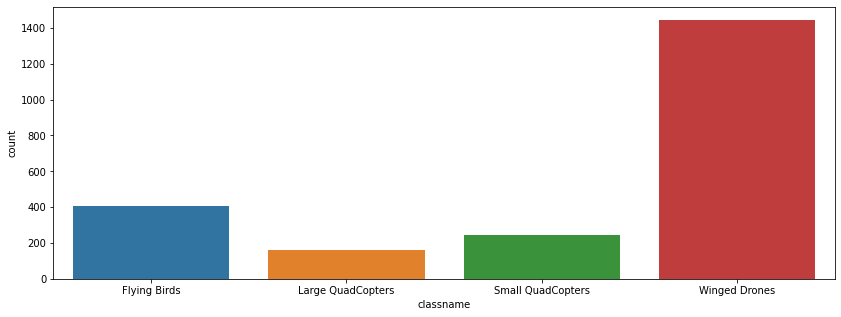

In [20]:
#plotting how the classes are distributed
fig, axs = plt.subplots(1,1,figsize=(14,5))
sns.countplot(df_duplicate["classname"], ax = axs)

In [21]:
df_duplicate.head()

,filename,classname,errornous_file,duplicate,parent_img
397,Flying Birds/fb_img_0430.jpg,Flying Birds,0,1,Flying Birds/flying-common-raven-picture-id117...
470,Flying Birds/animal-photography-bird-flying-50...,Flying Birds,0,1,Flying Birds/white-bird-50685.jpg
613,Flying Birds/Copy of 4d34f43aadc32f89c38c37493...,Flying Birds,0,1,Flying Birds/4d34f43aadc32f89c38c37493eed81170...
904,Flying Birds/ZHATuKpukACkWHz5ObmLRgHaEK.jpg,Flying Birds,0,1,Flying Birds/image132.jpg
958,Flying Birds/aFrDNzUEXrI.jpg,Flying Birds,0,1,Flying Birds/photo-1512830488078-82f3fda58d65.jpg


### Just visualize whether two marked duplicate files are actaully duplicate or not

In [22]:
testid = 200
file1 = "{}/{}".format(root_dataset, df_duplicate.iloc[testid]["filename"])
file2 = "{}/{}".format(root_dataset, df_duplicate.iloc[testid]["parent_img"])

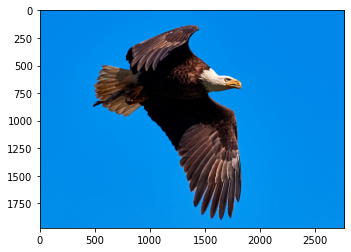

In [23]:
from PIL import Image
im1 = Image.open(file1)
plt.imshow(im1)

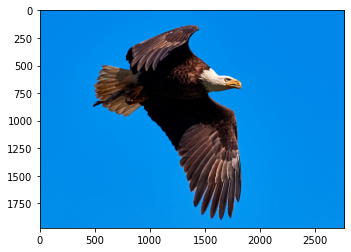

In [24]:
im2 = Image.open(file2)
plt.imshow(im2)

In [25]:
# Dataset summary after removing duplicates
df_dataset_no_dup = df_dataset[df_dataset['duplicate'] == 0]
print(f'Dataset summay after removing duplicates within classes: \nTotal count: {len(df_dataset_no_dup)}')
df_dataset_no_dup['classname'].value_counts()

Dataset summay after removing duplicates within classes: 
Total count: 19547


Flying Birds         7931
Winged Drones        4230
Large QuadCopters    4010
Small QuadCopters    3376
Name: classname, dtype: int64

# Find duplicate image file across class category..

This check whether sampe image files exist in multiple classess or not

In [26]:
def find_duplicates_across_class(rootdir, df_data):
    dvalues = df_data[df_data["duplicate"] == 0].values #filter unique values
    hash_keys = dict()
    dupCnt = 0
    pbar = tqdm(dvalues)
    for idx, item in enumerate(pbar):
      filename = dvalues[idx][0]
      filepath = f'{rootdir}/{filename}'  
      with open(filepath, 'rb') as f:
        filehash = hashlib.md5(f.read()).hexdigest()

      if filehash not in hash_keys:
        hash_keys[filehash] = [filename, dvalues[idx][1]] #filename, classname
      else:
        dupCnt += 1
        df_data.loc[df_data.filename == filename, 'cross_duplicate'] = 1
        df_data.loc[df_data.filename == filename, 'parent_img'] = hash_keys[filehash][0]
        df_data.loc[df_data.filename == filename, 'duplicate_class'] = hash_keys[filehash][1]

      pbar.set_description(desc=f'Processing: duplicate count: {dupCnt}')
    return

In [27]:
df_dataset["cross_duplicate"] = 0 # set to 1, if same image is found in another class
df_dataset["duplicate_class"] = "" # reference to other class where duplicate file exists. valid when cross_duplicate=1
find_duplicates_across_class(root_dataset, df_dataset)

Processing: duplicate count: 104: 100%|██████████| 19547/19547 [00:49<00:00, 392.93it/s]


In [28]:
df_cross_dup = df_dataset[df_dataset['cross_duplicate'] == 1]
print(f'Total duplicate files: {len(df_cross_dup)}')
df_cross_dup.head()

Total duplicate files: 104


,filename,classname,errornous_file,duplicate,parent_img,cross_duplicate,duplicate_class
12578,Small QuadCopters/drone-flying-quadcopter-5618...,Small QuadCopters,0,0,Large QuadCopters/drone-flying-quadcopter-5618...,1,Large QuadCopters
12645,Small QuadCopters/uav.jpg,Small QuadCopters,0,0,Large QuadCopters/0274.jpg,1,Large QuadCopters
12659,Small QuadCopters/12518_1000x1000.jpg,Small QuadCopters,0,0,Large QuadCopters/12518_1000x1000.jpg,1,Large QuadCopters
12792,Small QuadCopters/Drone-resized.jpg,Small QuadCopters,0,0,Large QuadCopters/Drone-resized.jpg,1,Large QuadCopters
12794,Small QuadCopters/images(76)_copter.jpg,Small QuadCopters,0,0,Large QuadCopters/image15.jpg,1,Large QuadCopters


In [29]:
df = pd.crosstab(df_cross_dup["classname"], df_cross_dup["duplicate_class"],margins =True)
df

duplicate_class,Large QuadCopters,Small QuadCopters,All
classname,,,
Small QuadCopters,70,0,70
Winged Drones,15,19,34
All,85,19,104


### Sample view of duplictae images in two different classes

In [30]:
testid = 0
file1 = "{}/{}".format(root_dataset, df_cross_dup.iloc[testid]["filename"])
file2 = "{}/{}".format(root_dataset, df_cross_dup.iloc[testid]["parent_img"])

Image in Small QuadCopters: /content/eva4p2_s2_dataset2/Small QuadCopters/drone-flying-quadcopter-561803.jpg


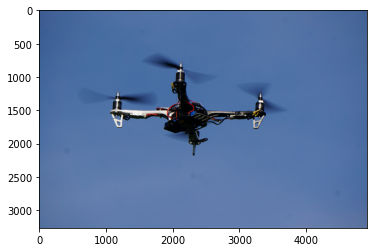

In [31]:
print(f'Image in {df_cross_dup.iloc[testid]["classname"]}: {file1}')
im = Image.open(file1)
plt.imshow(im)

Image in Large QuadCopters: /content/eva4p2_s2_dataset2/Large QuadCopters/drone-flying-quadcopter-561803.jpg
/content/eva4p2_s2_dataset2/Large QuadCopters/drone-flying-quadcopter-561803.jpg


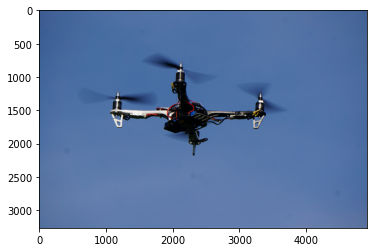

In [32]:
print(f'Image in {df_cross_dup.iloc[testid]["duplicate_class"]}: {file2}')
print(file2)
im = Image.open(file2)
plt.imshow(im)

In [33]:
df_remove = df_dataset[(df_dataset['duplicate'] == 1) | (df_dataset['cross_duplicate'] == 1) | (df_dataset['errornous_file'] == 1)]
print(f'File to removes: {len(df_remove)}')
df_remove['classname'].value_counts()

File to removes: 2376


Winged Drones        1486
Flying Birds          407
Small QuadCopters     317
Large QuadCopters     166
Name: classname, dtype: int64

# Save all the error, duplicate records in csv files

In [34]:
df_dataset.to_csv("eda_duplicate_list.csv")

# Remove all erronous files and duplicate files

In [35]:
df_remove.head()

,filename,classname,errornous_file,duplicate,parent_img,cross_duplicate,duplicate_class
397,Flying Birds/fb_img_0430.jpg,Flying Birds,0,1,Flying Birds/flying-common-raven-picture-id117...,0,
470,Flying Birds/animal-photography-bird-flying-50...,Flying Birds,0,1,Flying Birds/white-bird-50685.jpg,0,
613,Flying Birds/Copy of 4d34f43aadc32f89c38c37493...,Flying Birds,0,1,Flying Birds/4d34f43aadc32f89c38c37493eed81170...,0,
904,Flying Birds/ZHATuKpukACkWHz5ObmLRgHaEK.jpg,Flying Birds,0,1,Flying Birds/image132.jpg,0,
958,Flying Birds/aFrDNzUEXrI.jpg,Flying Birds,0,1,Flying Birds/photo-1512830488078-82f3fda58d65.jpg,0,


In [36]:
def remove_files(rootdir, df_data):
    dvalues = df_data.values
    pbar = tqdm(dvalues)
    for idx, item in enumerate(pbar):
      filename = dvalues[idx][0]
      filepath = f'{rootdir}/{filename}'  
      os.remove(filepath)
      pbar.set_description(desc=f'Removing files..')
    return

In [37]:
remove_files(root_dataset, df_remove)

Removing files..: 100%|██████████| 2376/2376 [00:03<00:00, 651.37it/s]


In [46]:
# check the final dataset summary used for model building
get_dataset_count(root_dataset, class_list)

Flying Birds: 7931 images
Large QuadCopters: 4003 images
Small QuadCopters: 3306 images
Winged Drones: 4189 images

Total images: 19429


In [42]:
import shutil
out_dataset_dir = '/content/gdrive/My Drive/TSAI/EVA4_Phase2/datasets/session2/s2_dataset_v1'

In [44]:
import os, shutil
def make_archive(source, destination):
        base = os.path.basename(destination)
        name = base.split('.')[0]
        format = base.split('.')[1]
        archive_from = os.path.dirname(source)
        archive_to = os.path.basename(source.strip(os.sep))
        print(source, destination, archive_from, archive_to)
        shutil.make_archive(name, format, archive_from, archive_to)
        shutil.move('%s.%s'%(name,format), destination)

#make_archive('/path/to/folder', '/path/to/folder.zip')


In [51]:
out_root_dir = '/content/gdrive/My Drive/TSAI/EVA4_Phase2/datasets/session2/s2_dataset_v1_a'

In [53]:
if Path(out_root_dir).exists():
  shutil.rmtree(out_root_dir)

In [54]:
Path(out_root_dir).mkdir(exist_ok=True)

In [55]:
for classname in class_list:
  src_dir = f'{root_dataset}/{classname}'
  out_dir = f'{out_root_dir}/{classname}.zip'
  make_archive(src_dir, out_dir)

/content/eva4p2_s2_dataset2/Flying Birds /content/gdrive/My Drive/TSAI/EVA4_Phase2/datasets/session2/s2_dataset_v1/Flying Birds.zip /content/eva4p2_s2_dataset2 Flying Birds
/content/eva4p2_s2_dataset2/Large QuadCopters /content/gdrive/My Drive/TSAI/EVA4_Phase2/datasets/session2/s2_dataset_v1/Large QuadCopters.zip /content/eva4p2_s2_dataset2 Large QuadCopters
/content/eva4p2_s2_dataset2/Small QuadCopters /content/gdrive/My Drive/TSAI/EVA4_Phase2/datasets/session2/s2_dataset_v1/Small QuadCopters.zip /content/eva4p2_s2_dataset2 Small QuadCopters
/content/eva4p2_s2_dataset2/Winged Drones /content/gdrive/My Drive/TSAI/EVA4_Phase2/datasets/session2/s2_dataset_v1/Winged Drones.zip /content/eva4p2_s2_dataset2 Winged Drones


In [ ]:
# 'Flying Birds', 'Large QuadCopters', 'Small QuadCopters', 'Winged Drones'